# 3: Complex wind
-----------------

In this exercise we look at the complex wind of $\pi^{1}\text{Gru}$.

In [91]:
import numpy             as np
import matplotlib.pyplot as plt
import magritte.tools    as tools
import magritte.plot     as plot
import magritte.setup    as setup
import magritte.core     as magritte
import magritte.mesher   as mesher

from astropy       import units, constants
from astropy.io    import fits
from scipy.spatial import Delaunay

In [92]:
# Define names for the data files
model_file = 'output/magritte_complex_wind.hdf5'
lamda_file = 'data/co_cut_12.txt'

You will modify two parameters to find the best fit model: the inclination of the system (relative to the line of sight, so 0$^\circ$ is a face-on torus) and the velocity of the gas in the torus component

In [159]:
velocity_torus = 8  # in km/s
inclination    = 0  # in degrees

In [160]:
# Define other model parameters
R1    = (2000.0 * units.au        ).si.value  # outer radius of the torus
R3    = (3300.0 * units.au        ).si.value  # outer radius of the bipolar wind
d     = ( 270.0 * units.au        ).si.value  # inner diameter of the torus
h     = ( 130.0 * units.au        ).si.value  # h/2 = starting radius of the bipolar wind
φ0    = (  25.0 * units.deg       ).si.value  # 2φ0 = opening angle of the flared disk torus
#v1a   = (   8.0 * units.km/units.s).si.value  # constant for the velocity profile of the torus
#v1b   = (   5.0 * units.km/units.s).si.value  # constant for the velocity profile of the torus
v3a   = (  11.0 * units.km/units.s).si.value  # constant for the velocity profile of the bipolar outflow
v3b   = (  89.0 * units.km/units.s).si.value  # constant for the velocity profile of the bipolar outflow
T0    = ( 190.0 * units.K         ).si.value  # initial temperature at r = 1e15 cm = h/2
n3a   = (5.0e+6 * units.cm**(-3)  ).si.value  # scaling factor for the density profile of the bipolar wind
n1a   =  25 * n3a                             # scaling factor for the density profile of the torus
fφ0   =  2.5                                  # value of fφ at the top and bottom edges of the torus
α     =  0.0                                  # -3+α = exponent of the density profile of the bipolar wind
β     = -0.15                                 # -0.7+β = exponent of the temperature profile

X_CO   =  6.5e-4   # fractional abundance of CO relative to H2 (Knapp et al. 1999)
v_turb = (1.0 * units.km/units.s).si.value    # turbulent velocity
aperture =  25 * units.arcsec  # aperture to extract the spectrum
distance = 150 # in parsec
v_rel = -11  # relative radial velocity of pi1 Gru, in km/s
r_in  = h/2    # inner boundary of the model
r_out = R3     # outer boundary of the model

# Give the torus velocity in m/s and the inclination in radians
velocity_torus_si = (velocity_torus * units.km/units.s).si.value 
inclination_rad   = (inclination    * units.deg       ).si.value

def cartesian_to_spherical(x, y, z):
    """
    Convert cartesian to spherical coordinates.
    """
    r = np.sqrt(x**2 + y**2 + z**2)
    φ = np.pi/2 - np.arccos(z / r)
    θ = np.arctan2(y, x)
    φ = np.nan_to_num(φ, nan=0.0)
    return (r, φ, θ)


def fφ(φ):
    """
    Linear function, used to define the torus shape
    """
    return 1.0 + np.abs(φ/φ0) * fφ0 


def mask_1(r, φ, θ):
    """
    Mask for component 1: torus.
    """
    return np.logical_and(r > d/2, np.logical_and(r < R1, np.abs(φ) <= φ0))


def mask_3(r, φ, θ):
    """
    Mask for component 3: bipolar outflow.
    """
    return np.logical_and(r > h/2, np.logical_and(r < R3, np.abs(φ) >= φ0))


def number_density_H2(x, y, z):
    """
    H2 number density distributions
    """
    r, φ, θ = cartesian_to_spherical(x, y, z)
    # Get the masks for the different components
    m1 = mask_1(r, φ, θ)
    m3 = mask_3(r, φ, θ)
    # Initialize the number density array
    #nH2 = 1.0e+3*np.ones_like(r)
    nH2 = np.zeros_like(r)
    # H2 number density distribution of the torus
    n1 = n1a * (r / (1.0e+15 * units.cm).si.value)**(-3) * 1.0 / fφ(φ)
    # H2 number density distribution of the bipolar outflow
    n3 = n3a * (r / (1.0e+15 * units.cm).si.value)**(-3+α)
    # Apply masks
    nH2[m3] = n3[m3]
    nH2[m1] = n1[m1]
    # Return the H2 number density
    return nH2


# def velocity(x, y, z):
#     """
#     Velocity distributions
#     """
#     r, φ, θ = cartesian_to_spherical(x, y, z)
#     # Get the masks for the different components
#     m1 = mask_1(r, φ, θ)
#     m3 = mask_3(r, φ, θ)
#     # Initialize the velocity array
#     vr = np.zeros_like(r)
#     # Radial velocity of component one
#     v1 = (v1a + v1b * r / R1) * fφ(φ)
#     # Radial velocity of component three
#     v3 =  v3a + v3b * z / R3
#     # Apply masks
#     vr[m1] = v1[m1]
#     vr[m3] = v3[m3]
#     # Return the three cartesian components of the velocity vector
#     return np.array((vr*x/r, vr*y/r, vr*z/r)).T

# Simplified velocity structure, with a single velocity for the torus component
def velocity(x, y, z):
    """
    Velocity distributions
    """
    r, φ, θ = cartesian_to_spherical(x, y, z)
    # Get the masks for the different components
    m1 = mask_1(r, φ, θ)
    m3 = mask_3(r, φ, θ)
    # Initialize the velocity array
    vr = np.zeros_like(r)
    # Radial velocity of component
    v1 = velocity_torus_si
    # Radial velocity of component
    v3 = v3a + v3b * np.abs(z) / R3
    # Apply masks
    vr[m3] = v3[m3]
    vr[m1] = v1
    # Return the three cartesian components of the velocity vector
    return np.array((vr*x/r, vr*y/r, vr*z/r)).T


def temperature(x, y, z):
    """
    Temperature distribution.
    """
    r, φ, θ = cartesian_to_spherical(x, y, z)
    # Temperature distribution
    return T0 * (r / (1.0e+15 * units.cm).si.value)**(-0.7+β)

In [161]:
## Create a point cloud for the model

resolution = 75

# Create coordinate axis for the background mesh
xs = np.linspace(-r_out, +r_out, resolution, endpoint=True)
ys = np.linspace(-r_out, +r_out, resolution, endpoint=True)
zs = np.linspace(-r_out, +r_out, resolution, endpoint=True)

# Create a background mesh
(Xs, Ys, Zs) = np.meshgrid(xs, ys, zs)

# Extract positions of points in background mesh
position = np.array((Xs.ravel(), Ys.ravel(), Zs.ravel())).T

# Evaluate a tracer (here the H2 number density density) on the background mesh
tracer      = number_density_H2(Xs, Ys, Zs)
tracer_min  = np.min(tracer[tracer!=0.0])   # Find smallest non-zero value
tracer     += tracer_min                    # add smallest non-zero value to avoid zeros

# Create a point cloud for the model
positions_reduced, nb_boundary = mesher.remesh_point_cloud(
    positions = position,
    data      = tracer.ravel(),
    max_depth = 10,
    threshold = 2.0e-1,
    hullorder = 4
)

# Add inner boundary to the model
positions_reduced, nb_boundary = mesher.point_cloud_add_spherical_inner_boundary(
    remeshed_positions = positions_reduced,
    nb_boundary        = nb_boundary,
    radius             = r_in,
    healpy_order       = 5,
    origin             = np.array([0.0, 0.0, 0.0]).T
)

# Add outer boundary to the model
positions_reduced, nb_boundary = mesher.point_cloud_add_spherical_outer_boundary(
    remeshed_positions = positions_reduced,
    nb_boundary        = nb_boundary,
    radius             = r_out,
    healpy_order       = 15,
    origin             = np.array([0.0, 0.0, 0.0]).T
)

# Numbenr of points in the model
npoints = len(positions_reduced)

# Extract Delaunay vertices (= Voronoi neighbors)
delaunay = Delaunay(positions_reduced)
(indptr, indices) = delaunay.vertex_neighbor_vertices
neighbors = [indices[indptr[k]:indptr[k+1]] for k in range(npoints)]
nbs       = [n for sublist in neighbors for n in sublist]
n_nbs     = [len(sublist) for sublist in neighbors]

new interior points:  51463
number boundary points:  1538


In [162]:
position = positions_reduced
velocity = velocity         (position[:,0], position[:,1], position[:,2])
tmp      = temperature      (position[:,0], position[:,1], position[:,2])
nH2      = number_density_H2(position[:,0], position[:,1], position[:,2])
nCO      = X_CO * nH2
trb      = v_turb * np.ones (npoints)

In [163]:
model = magritte.Model ()                      # Create model object

model.parameters.set_model_name (model_file)   # Magritte model file
model.parameters.set_dimension  (3)            # This is a 3D model
model.parameters.set_npoints    (npoints)      # Number of points
model.parameters.set_nrays      (12)           # Number of rays
model.parameters.set_nspecs     (3)            # Number of species (min. 5)
model.parameters.set_nlspecs    (1)            # Number of line species
model.parameters.set_nquads     (5)            # Number of quadrature points
model.parameters.pop_prec       =1.0e-4        # Population convergence criterion

model.geometry.points.position.set(position)
model.geometry.points.velocity.set(velocity / constants.c.si.value)   # velocities w.r.t. speed of light 

model.geometry.points.  neighbors.set(  nbs)
model.geometry.points.n_neighbors.set(n_nbs)

model.chemistry.species.abundance = np.array((nCO, nH2, np.zeros(npoints))).T
model.chemistry.species.symbol    = ['CO', 'H2', 'e-']

model.thermodynamics.temperature.gas  .set( tmp                         )
model.thermodynamics.turbulence.vturb2.set((trb/constants.c.si.value)**2)

model.parameters.set_nboundary(nb_boundary)
model.geometry.boundary.boundary2point.set(np.arange(nb_boundary))

# direction = np.array([[+1,0,0], [-1,0,0]])            # Comment out to use all directions
# model.geometry.rays.direction.set(direction)          # Comment out to use all directions
# model.geometry.rays.weight   .set(0.5 * np.ones(2))   # Comment out to use all directions

model = setup.set_uniform_rays            (model)   # Uncomment to use all directions
model = setup.set_boundary_condition_CMB  (model)
# model = setup.set_linedata_from_LAMDA_file(model, lamda_file, {'considered transitions': [0]})
model = setup.set_linedata_from_LAMDA_file(model, lamda_file)   # Consider all transitions
model = setup.set_quadrature              (model)

# Write and read model to initialize all variables
model.write()
model.read ()

Writing parameters...
Writing points...
Writing rays...
Writing boundary...
Writing chemistry...
Writing species...
Writing thermodynamics...
Writing temperature...
Writing turbulence...
Writing lines...
Writing lineProducingSpecies...
Writing linedata...
ncolpoar = 2
--- colpoar = 0
Writing collisionPartner...
(l, c) = 0, 0
--- colpoar = 1
Writing collisionPartner...
(l, c) = 0, 1
Writing quadrature...
Writing populations...
Writing radiation...
Writing frequencies...
                                           
-------------------------------------------
  Reading Model...                         
-------------------------------------------
 model file = output/magritte_complex_wind.hdf5
-------------------------------------------
Reading parameters...
Reading points...
Reading rays...
Reading boundary...
Reading chemistry...
Reading species...
Reading thermodynamics...
Reading temperature...
Reading turbulence...
Reading lines...
Reading lineProducingSpecies...
Reading linedata...
re

In [164]:
# Initialize model with LTE level populations
model.compute_spectral_discretisation ()
model.compute_inverse_line_widths     ()
model.compute_LTE_level_populations   ()

Computing spectral discretisation...
Computing inverse line widths...
Computing LTE level populations...


0

In [165]:
# Iterate level populations until statistical equilibrium
model.compute_level_populations_sparse (True, 20)

using ng acceleration? 0
Starting iteration 1
Computing the radiation field...
Computing radiation field...
--- rr = 0
--- rr = 1
--- rr = 2
--- rr = 3
--- rr = 4
--- rr = 5
Tot | Compute Radiation Field : 33.503271 seconds
Minor warning: population inversions detected; Magritte does not handle masers, so setting affected populations to LTE.
Tot | Compute Statistical Equilibrium : 0.393680 seconds
Already 44.4735 % converged!
using ng acceleration? 0
Starting iteration 2
Computing the radiation field...
Computing radiation field...
--- rr = 0
--- rr = 1
--- rr = 2
--- rr = 3
--- rr = 4
--- rr = 5
Tot | Compute Radiation Field : 67.715334 seconds
Minor warning: population inversions detected; Magritte does not handle masers, so setting affected populations to LTE.
Tot | Compute Statistical Equilibrium : 0.727783 seconds
Already 44.7992 % converged!
using ng acceleration? 0
Starting iteration 3
Computing the radiation field...
Computing radiation field...
--- rr = 0
--- rr = 1
--- rr = 2

10

In [166]:
line_nr = 2 # CO (J=3-2)
# Read in the observed CO 3-2 spectrum
velo, flux_density = np.loadtxt('data/pi1_Gru_CO32_spec.dat', unpack=True)
velmask = np.logical_and(velo > -50.0, velo < 26.0)
nfreqs = len(velo[velmask])   # number of velocity elements (same as data)
vpix   = (velo[1]-velo[0])*1e3   # velocity pixel size [m/s]
#nfreqs  =  100
#vpix    = 2000.0   # velocity pixel size [m/s]
fcen    = model.lines.lineProducingSpecies[0].linedata.frequency[line_nr]
dd      = vpix * (nfreqs-1)/2 / magritte.CC
fmin    = fcen - fcen*dd
fmax    = fcen + fcen*dd

# Define the angle at which to view the model (inclination)
rx = 0.0
ry = np.sin(inclination_rad)
rz = np.cos(inclination_rad)

model.compute_spectral_discretisation(fmin, fmax, nfreqs)
model.compute_image_new               (rx, ry, rz, 512, 512)#in which (rx, ry, rz) is the (normalized) ray direction

--- rr = 5
Tot | Compute Radiation Field : 101.139666 seconds
Minor warning: population inversions detected; Magritte does not handle masers, so setting affected populations to LTE.
Tot | Compute Statistical Equilibrium : 1.218986 seconds
Already 58.1988 % converged!
using ng acceleration? 0
Starting iteration 4
Computing the radiation field...
Computing radiation field...
--- rr = 0
--- rr = 1
--- rr = 2
--- rr = 3
--- rr = 4
--- rr = 5
Tot | Compute Radiation Field : 135.112604 seconds
Minor warning: population inversions detected; Magritte does not handle masers, so setting affected populations to LTE.
Tot | Compute Statistical Equilibrium : 1.558994 seconds
Already 70.5634 % converged!
using ng acceleration? 0
Starting iteration 5
Computing the radiation field...
Computing radiation field...
--- rr = 0
--- rr = 1
--- rr = 2
--- rr = 3
--- rr = 4
--- rr = 5
Tot | Compute Radiation Field : 168.872783 seconds
Minor warning: population inversions detected; Magritte does not handle mase

0

In [167]:
# Save the model as a fits file, and rename it based on the modified parameters so the file is saved
tools.save_fits(model, dpc=distance)
!cp output/images/image.fits output/images/image_inc"$inclination"_vt"$velocity_torus".fits

# Open the model fits file, and read its header
with fits.open('output/images/image_inc{}_vt{}.fits'.format(inclination, velocity_torus)) as hdul:
    img = hdul[0].data[:, :, :]
    hdr = hdul[0].header

# Define a function to convert from angular to spatial scales
@units.quantity_input(angle='angle', distance='length')
def convert_angular_to_spatial(angle, distance):
    """
    Convert angles to distances assuming a certain distance.
    """
    angle    = angle   .to(units.arcsec).value
    distance = distance.to(units.pc    ).value
    return angle * distance * units.au

Written file to: /Users/sofiaw/git/StellarAtmospheres_assignments/ex3_complex_wind/output/images/image.fits


In [168]:
# Define the spatial scale
I, J = np.indices((img.shape[1], img.shape[2]))  # indices of the pixels in the image
I = I - hdr['CRPIX1']  # subtract the index of the central pixel, to center the indices
J = J - hdr['CRPIX2']
R = np.hypot(I,J)  # define radii from the centre of the model

# Define the aperture in which to extract a spectrum
ax = 0.5 * aperture / (hdr['CDELT1'] * units.deg).to(units.arcsec)
ay = 0.5 * aperture / (hdr['CDELT2'] * units.deg).to(units.arcsec)
ar = 0.5 * (abs(ax) + abs(ay))
apmask = (R < ar) 

# Extract spectrum scale from the model fits header
vsize = hdr['NAXIS3']
vref  = hdr['CRVAL3']
vdelt = hdr['CDELT3']
vpix  = hdr['CRPIX3']
velos_model  = (np.arange(vsize)-vpix)*vdelt+vref
velos_model /= 1.0e+3
velos_model  = velos_model + v_rel

# Define the spectrum
spectrum = np.array([im[apmask].sum() for im in img])

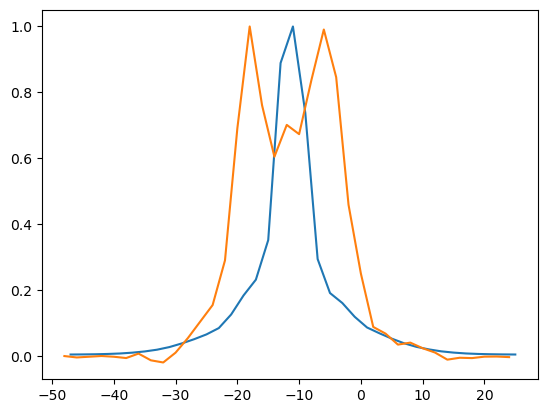

In [169]:
# Plot the data and model, with relative intensities
plt.plot(velos_model, spectrum/np.max(spectrum))
plt.plot(velo[velmask], flux_density[velmask]/np.max(flux_density))

In [170]:
# Calculate chi2 value

# Define a function to calculate reduced chi2
def chi2_calc(data_flux, model_flux, sigma):
    data_flux = np.array(data_flux)
    model_flux = np.array(model_flux)
    sigma = np.array(sigma)
    chi2 = np.sum((model_flux-data_flux)**2/sigma**2)/(len(data_flux)-2)
    return chi2

# Calculate the noise in the data spectrum
rms = np.std(flux_density[:11])
sigma = rms*np.ones(len(flux_density[velmask]))

chi2 = chi2_calc(flux_density[velmask]/np.max(flux_density), spectrum/np.max(spectrum), sigma)
print(chi2)

17.31411316793615


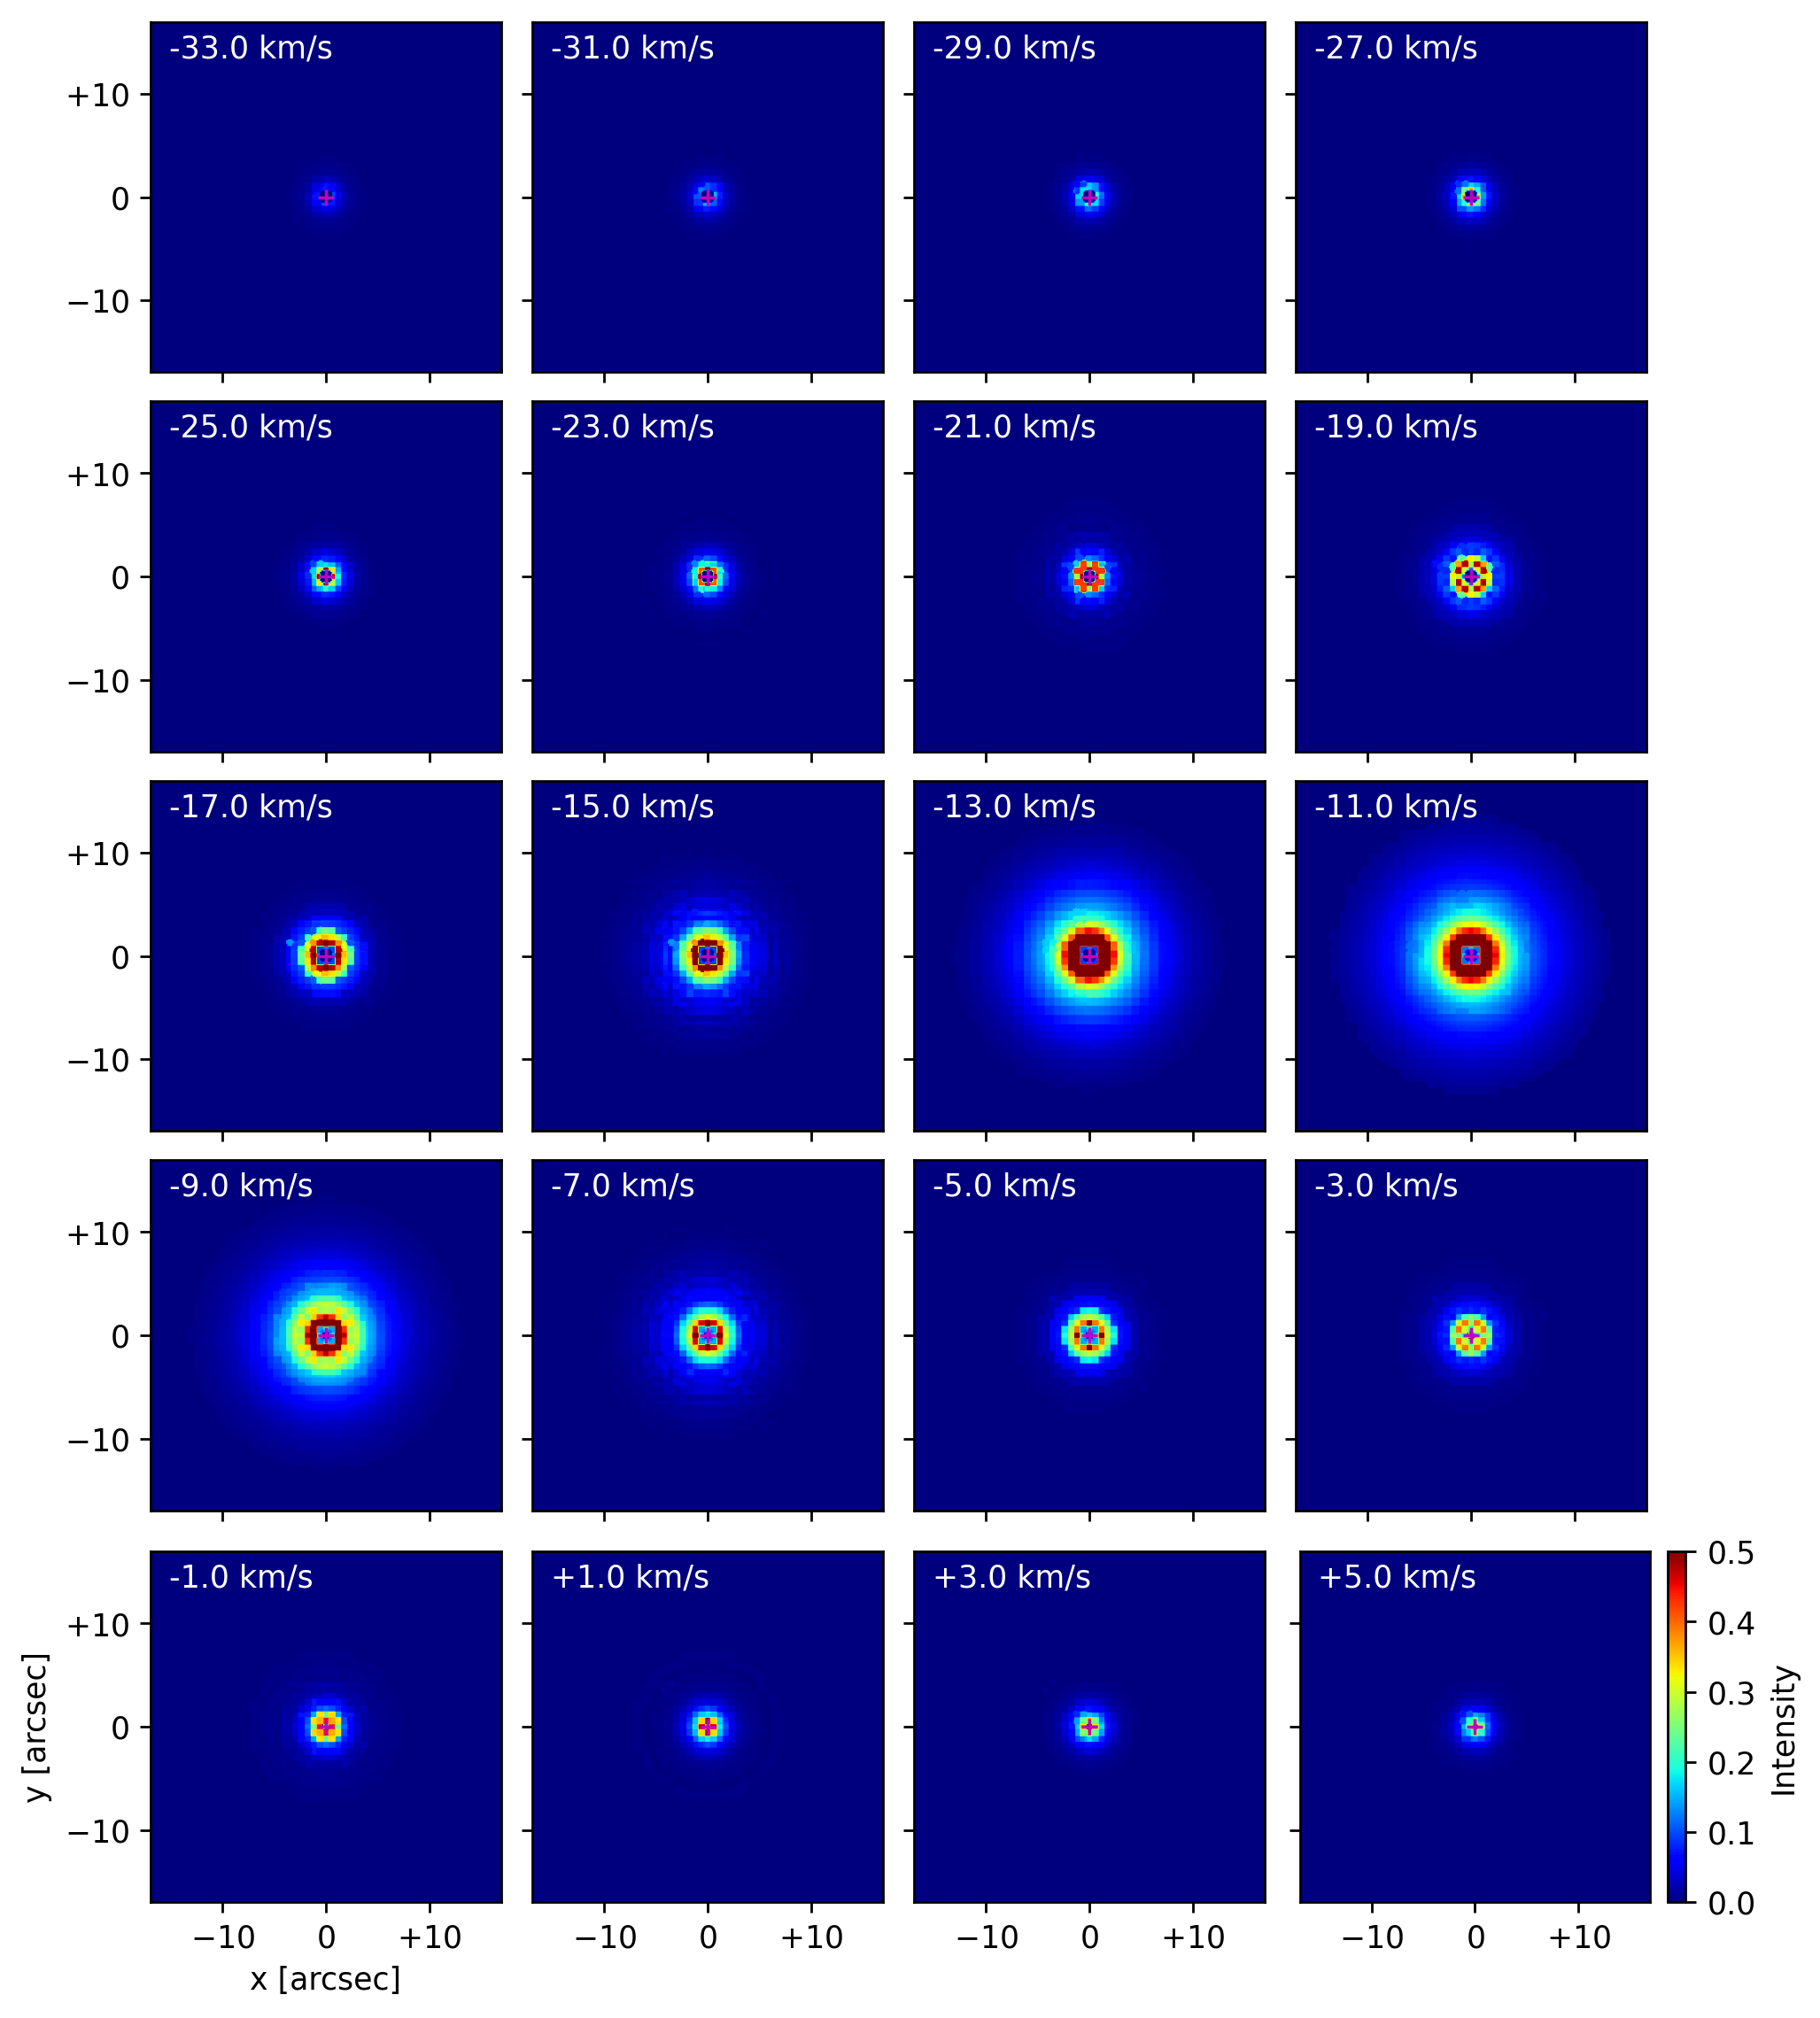

In [171]:
## Plot channel maps

# Divide the image by its maximum value to plot the relative intensity
img_rel = img/img.max()

# Define the range of velocities to plot
v_min = -34
v_max =  +6
to_plot = np.logical_and(v_min <= velos_model,  velos_model <= v_max)
img_to_plot = img_rel[to_plot]
velos_model_to_plot = velos_model[to_plot]

# Find the pixel values of +10, 0 and -10 arcseconds 
pixel_m10as = hdr['CRPIX1'] + (10 * units.arcsec / (hdr['CDELT1'] * units.deg).to(units.arcsec)).si.value
pixel_000as = hdr['CRPIX1']
pixel_p10as = hdr['CRPIX1'] - (10 * units.arcsec / (hdr['CDELT1'] * units.deg).to(units.arcsec)).si.value

# Define the subplots
fig, axes = plt.subplots(
    nrows       =   5,
    ncols       =   4,
    dpi         = 250,
    sharex      = True,
    sharey      = True,
    figsize     = (8.1, 9),
    gridspec_kw = {'wspace':0.00, 'hspace':0.00},
    layout      = 'constrained'
)

# For each velocity, plot the image
for i, ax in enumerate(axes.ravel()):
    # Plot the emission. Note that the color range can be modified by changing the vmin and vmax values
    pcm = ax.imshow(img_to_plot[i,:,:], vmin=0, vmax=0.5, cmap='jet')
    ax.plot(hdr['CRPIX1'], hdr['CRPIX2'], 'm+', markersize=5)
    ax.text(+15, +30, f'{velos_model_to_plot[i]:+.1f} km/s', color='white')
    ax.set_xticks([pixel_m10as, pixel_000as, pixel_p10as], ['$-10$', '$0$', '$+10$'])
    ax.set_yticks([pixel_m10as, pixel_000as, pixel_p10as], ['$+10$', '$0$', '$-10$'])

# Set axes labels and draw the colorbar
axes[4,0].set_xlabel('x [arcsec]')
axes[4,0].set_ylabel('y [arcsec]')
fig.colorbar(pcm, ax=ax, location='right', shrink=1.0, pad=0.05, label='Rel. intensity')

# Save the channel map as a pdf image
plt.savefig('output/images/pi1Gru_chmap_inc{}_vt{}.pdf'.format(inclination, velocity_torus), dpi=360)

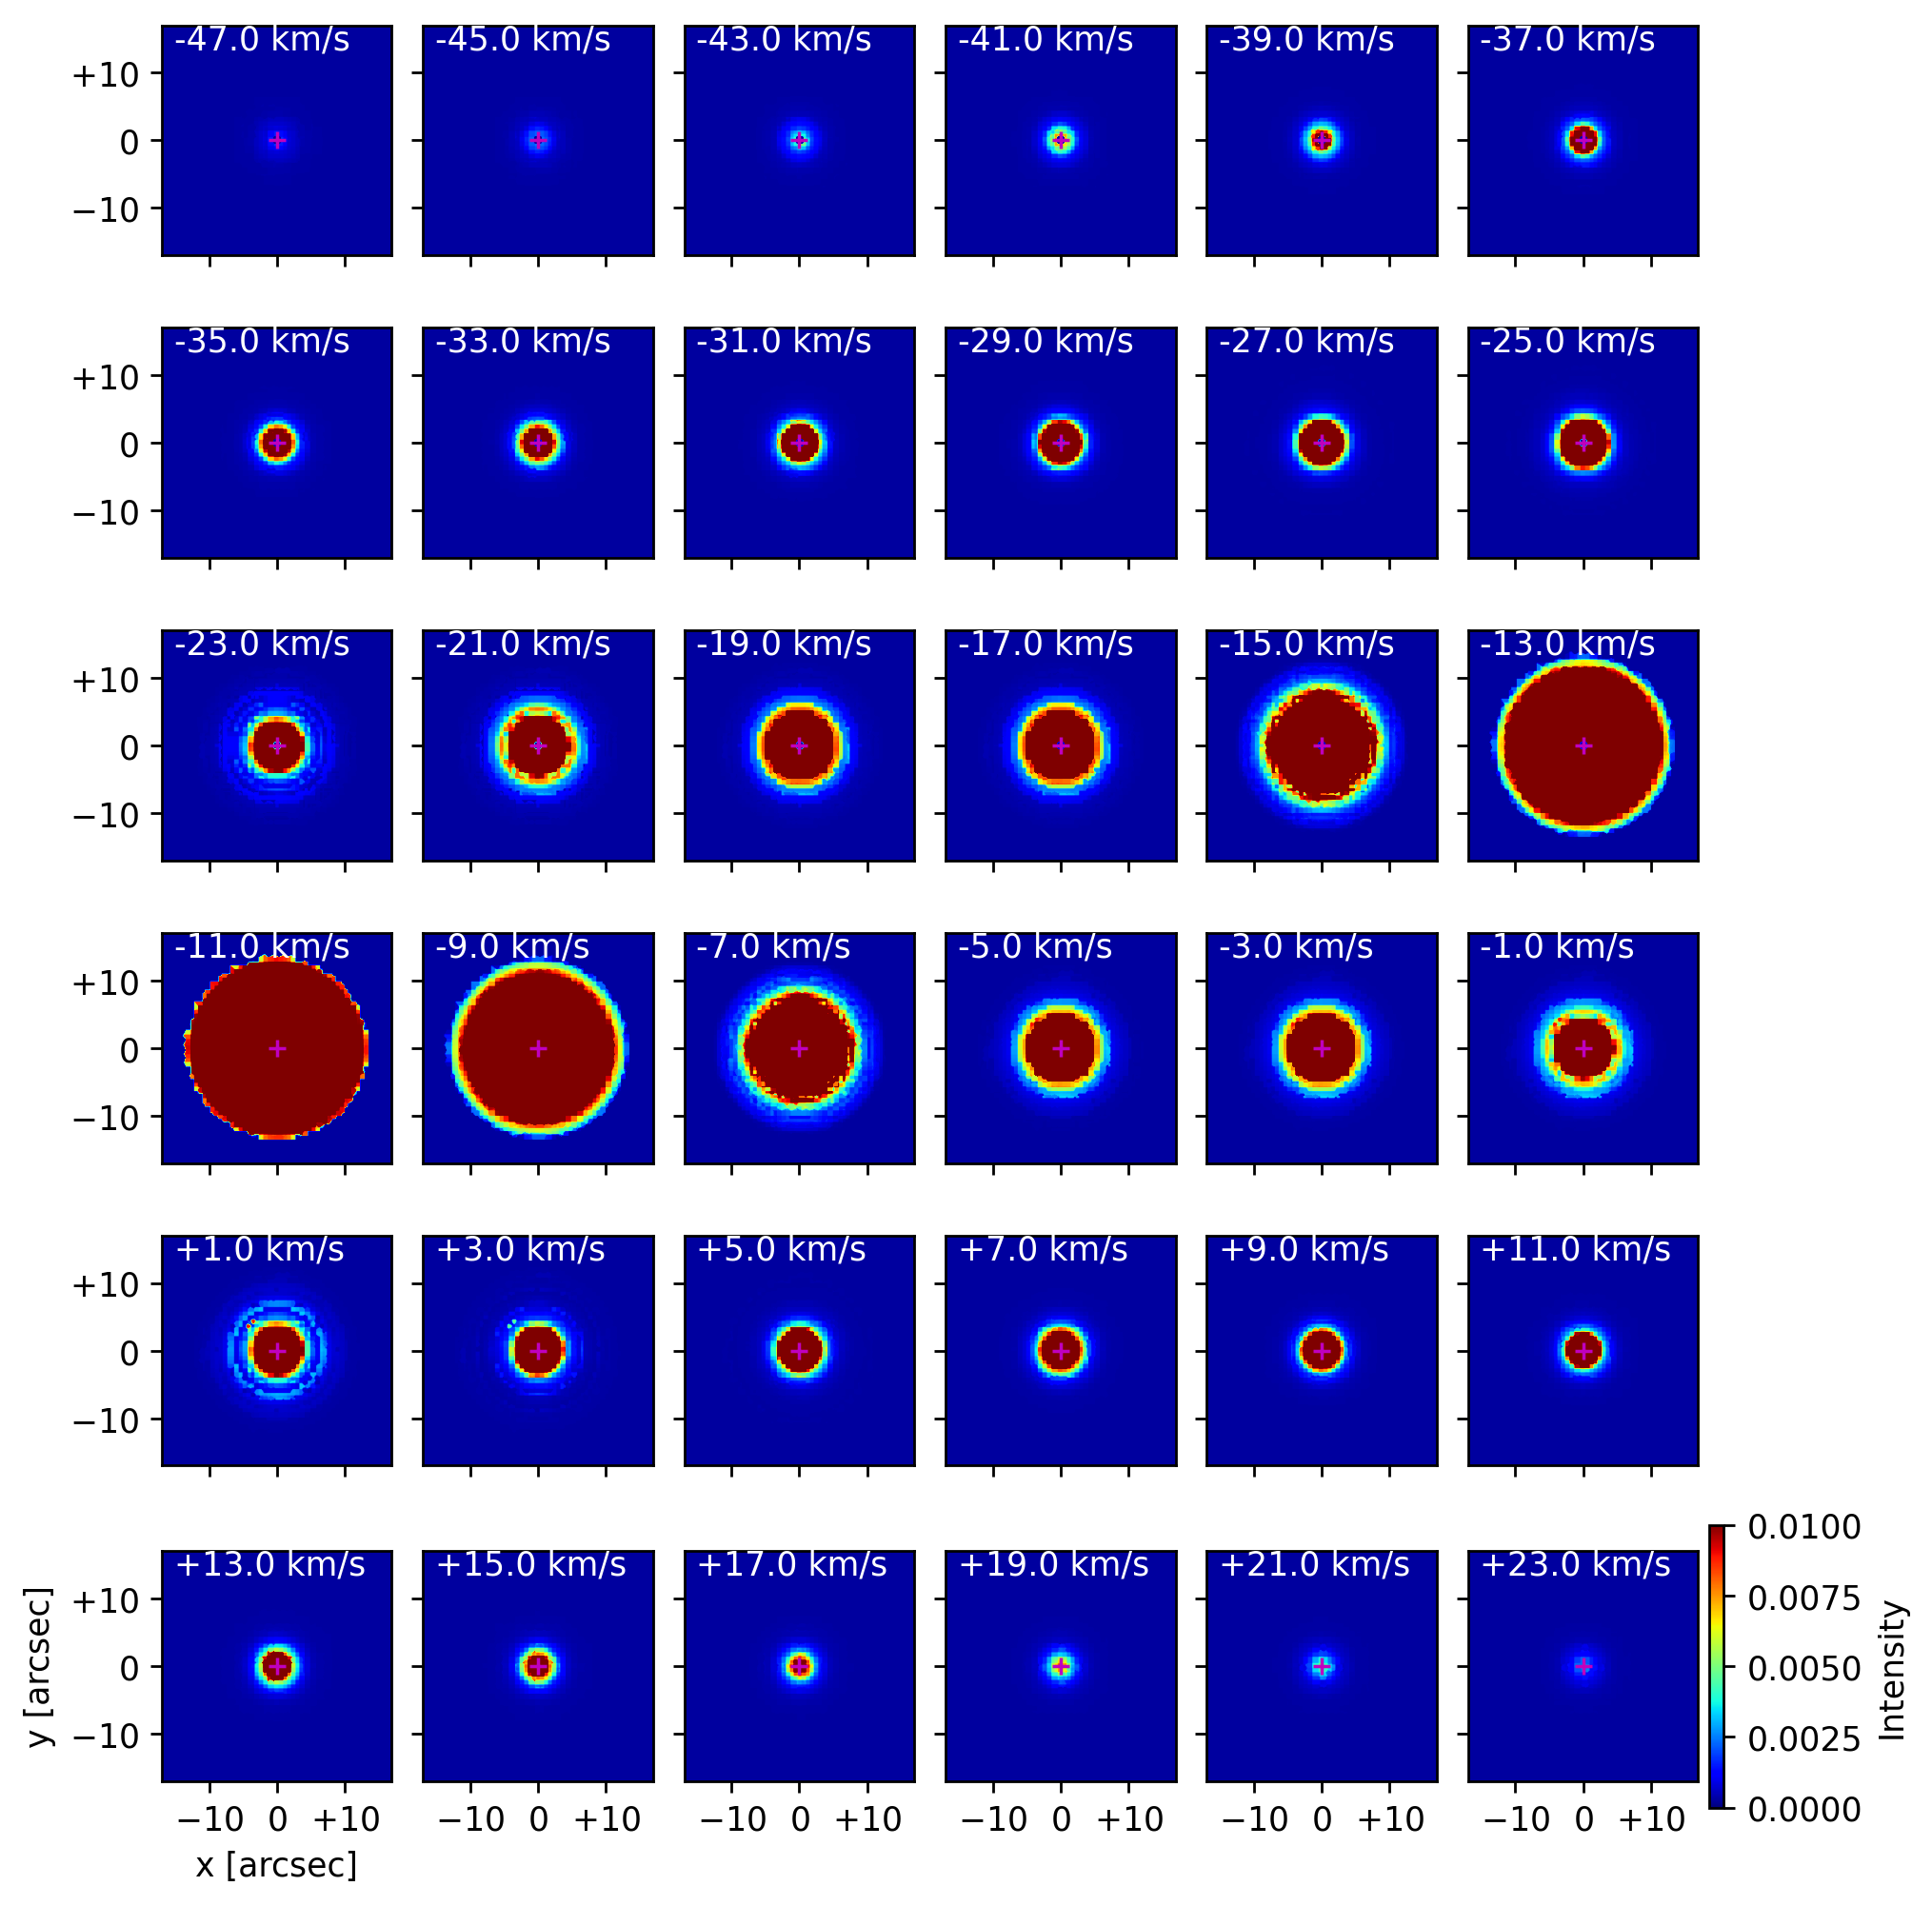

In [173]:
## Also plot extended channel maps, with a reduced color range to highlight the faint outer edges of the bipolar outflow

# Divide the image by its maximum value to plot the relative intensity
img_rel = img/img.max()

# Define the range of velocities to plot
v_min = -48
v_max = 23
to_plot = np.logical_and(v_min <= velos_model,  velos_model <= v_max)
img_to_plot = img_rel[to_plot]
velos_model_to_plot = velos_model[to_plot]

# Find the pixel values of +10, 0 and -10 arcseconds 
pixel_m10as = hdr['CRPIX1'] + (10 * units.arcsec / (hdr['CDELT1'] * units.deg).to(units.arcsec)).si.value
pixel_000as = hdr['CRPIX1']
pixel_p10as = hdr['CRPIX1'] - (10 * units.arcsec / (hdr['CDELT1'] * units.deg).to(units.arcsec)).si.value

# Define the subplots
fig, axes = plt.subplots(
    nrows       =   6,
    ncols       =   6,
    dpi         = 250,
    sharex      = True,
    sharey      = True,
    figsize     = (8, 8),
    gridspec_kw = {'wspace':0.00, 'hspace':0.00},
    layout      = 'constrained'
)

# For each velocity, plot the image
for i, ax in enumerate(axes.ravel()):
    # Plot the emission. Note that the color range can be modified by changing the vmin and vmax values
    pcm = ax.imshow(img_to_plot[i,:,:], vmin=0, vmax=0.01, cmap='jet')
    ax.plot(hdr['CRPIX1'], hdr['CRPIX2'], 'm+', markersize=5)
    ax.text(+15, +30, f'{velos_model_to_plot[i]:+.1f} km/s', color='white')
    ax.set_xticks([pixel_m10as, pixel_000as, pixel_p10as], ['$-10$', '$0$', '$+10$'])
    ax.set_yticks([pixel_m10as, pixel_000as, pixel_p10as], ['$+10$', '$0$', '$-10$'])

# Set axes labels and draw the colorbar
axes[5,0].set_xlabel('x [arcsec]')
axes[5,0].set_ylabel('y [arcsec]')
fig.colorbar(pcm, ax=ax, location='right', shrink=1.0, pad=0.05, label='Rel. intensity')

# Save the channel map as a pdf image
plt.savefig('output/images/pi1Gru_extendedchmap_inc{}_vt{}.pdf'.format(inclination, velocity_torus), dpi=360)